In [1]:
import pandas as pd
import seaborn as sns; 
import itertools

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import sqlite3 as lite
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
%matplotlib inline

In [30]:

df = pd.DataFrame()
# Loading the data

sim = pd.read_csv('runs/sim_run/value_log.csv', parse_dates=['Date'], index_col='Date')
sim.drop(['Unnamed: 0'], axis=1, inplace=True)

cntrl = pd.read_csv('runs/control/value_log.csv', parse_dates=['Date'], index_col='Date')
cntrl.drop(['Unnamed: 0'], axis=1, inplace=True)

wig20 = pd.read_csv('data/wig20_d.csv', parse_dates=['Data'], index_col='Data')
wig = pd.read_csv('data/wig_d.csv', parse_dates=['Data'], index_col='Data')

# Returns and value
sim['Return'] = np.log(sim['Value']) - np.log(sim['Value'].shift(1))

wig['Return'] = np.log(wig['Zamkniecie']) - np.log(wig['Zamkniecie'].shift(1))
wig['Value'] = wig['Return'].add(1).fillna(1).cumprod()*1000000

wig20['Return'] = np.log(wig20['Zamkniecie']) - np.log(wig20['Zamkniecie'].shift(1))
wig20['Value'] = wig20['Return'].add(1).fillna(1).cumprod()*1000000

cntrl['Return'] = np.log(cntrl['Value']) - np.log(cntrl['Value'].shift(1))

df['Sim_return'] = sim['Return']
df['Sim_value'] = sim['Value']
df['WIG_return'] = wig['Return']
df['WIG_value'] = wig['Value']
df['WIG20_return'] = wig20['Return']
df['WIG20_value'] = wig20['Value']
df['Control_return'] = cntrl['Return']
df['Control_value'] = cntrl['Value']

In [4]:
# Value over time - all 4
sns.set(rc={'figure.figsize':(13.7,10.27)})
sns.lineplot(data=[df.Sim_value, df.WIG_value, df.WIG20_value, df.Control_value])

In [3]:
# Value over time - split by portfolio 
f, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15,15))
sns.lineplot(data=df.Sim_value, label="Symulacja", ax=axes[0,0])
sns.lineplot(data=df.WIG_value, label="WIG", ax=axes[0,1])
sns.lineplot(data=df.WIG20_value, label="WIG", ax=axes[1,0])
sns.lineplot(data=df.Control_value, label="Portfolio kontrolne", ax=axes[1,1])

Date
2012    AxesSubplot(0.125,0.2;0.775x0.68)
2013    AxesSubplot(0.125,0.2;0.775x0.68)
2014    AxesSubplot(0.125,0.2;0.775x0.68)
2015    AxesSubplot(0.125,0.2;0.775x0.68)
2016    AxesSubplot(0.125,0.2;0.775x0.68)
2017    AxesSubplot(0.125,0.2;0.775x0.68)
dtype: object

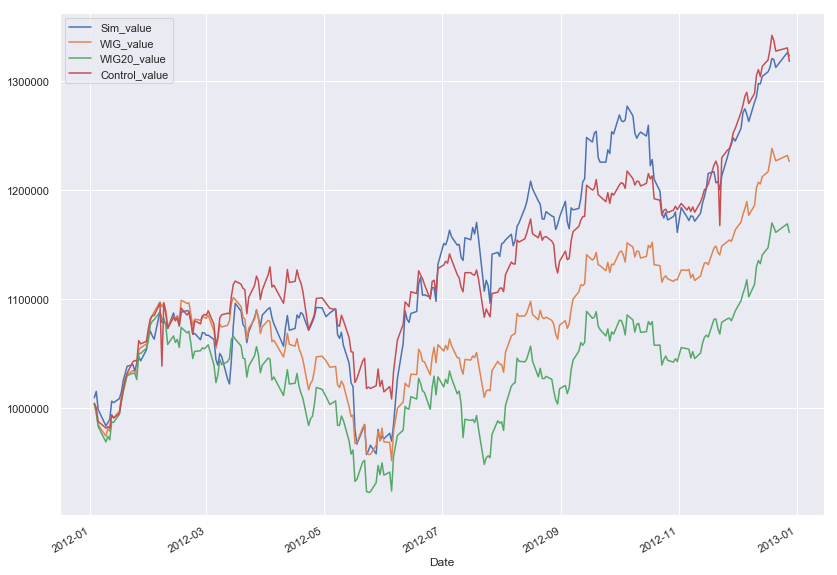

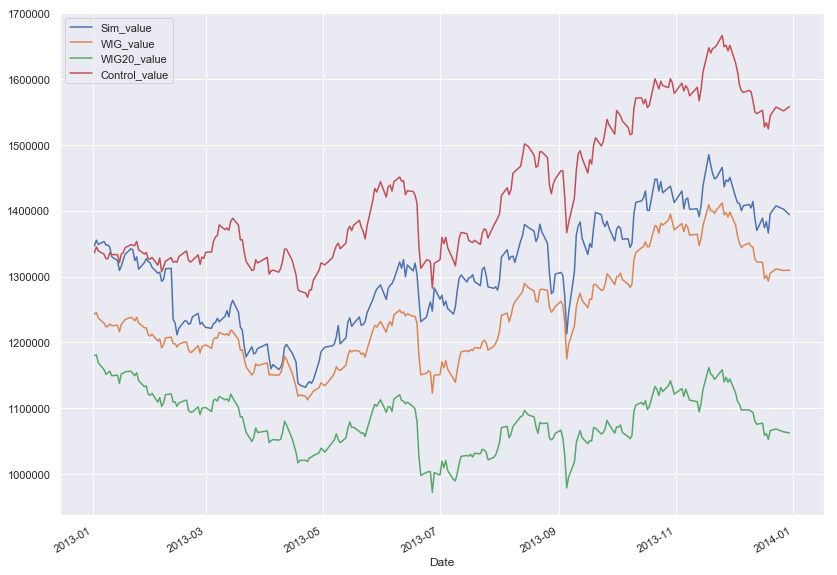

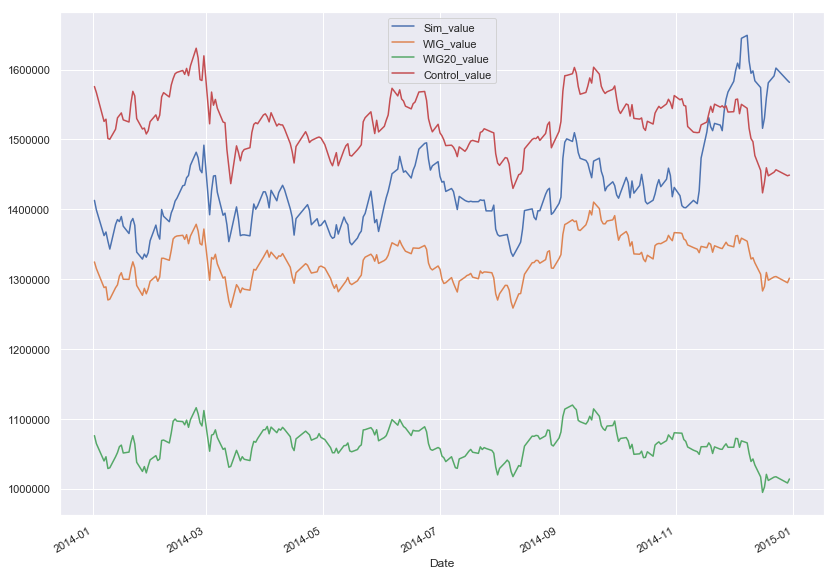

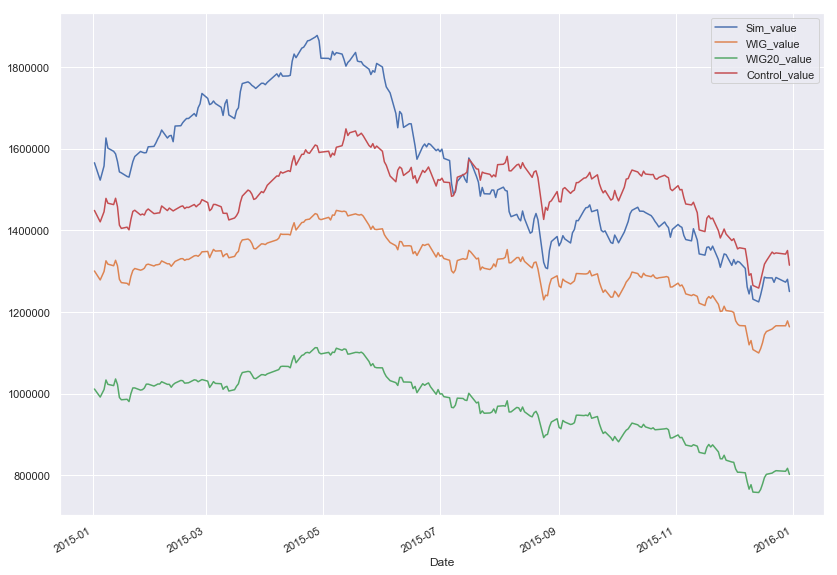

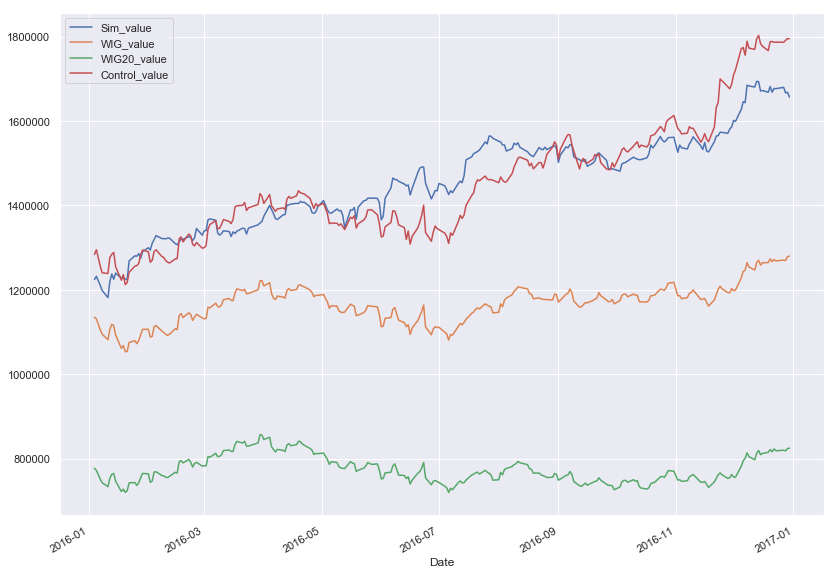

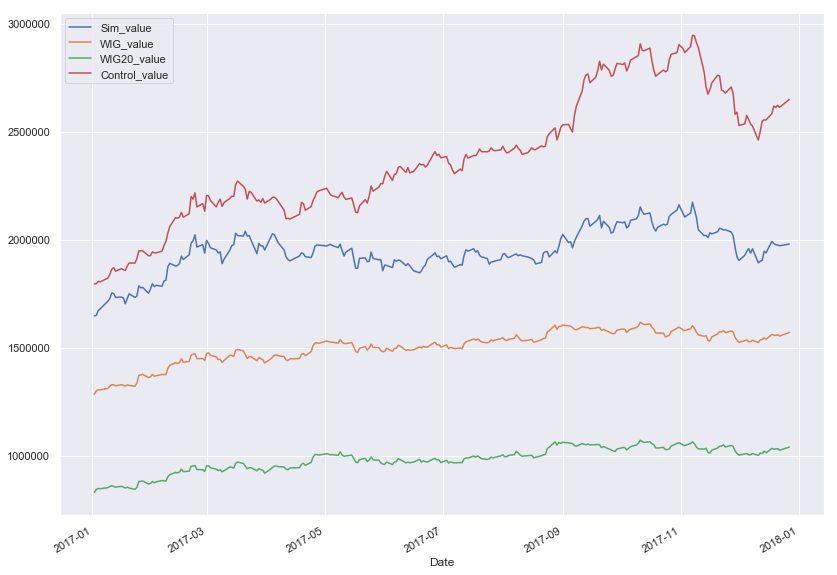

In [201]:
# Value by year


grouped = df[['Sim_value', 'WIG_value', 'WIG20_value', 'Control_value']].groupby([df.index.year])
grouped.plot()
# ncols=2
# nrows = int(np.ceil(grouped.ngroups/ncols))
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,20), sharey=True)


# for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
#     grouped.get_group(key).plot(ax=ax)

# ax.legend()
# plt.show()



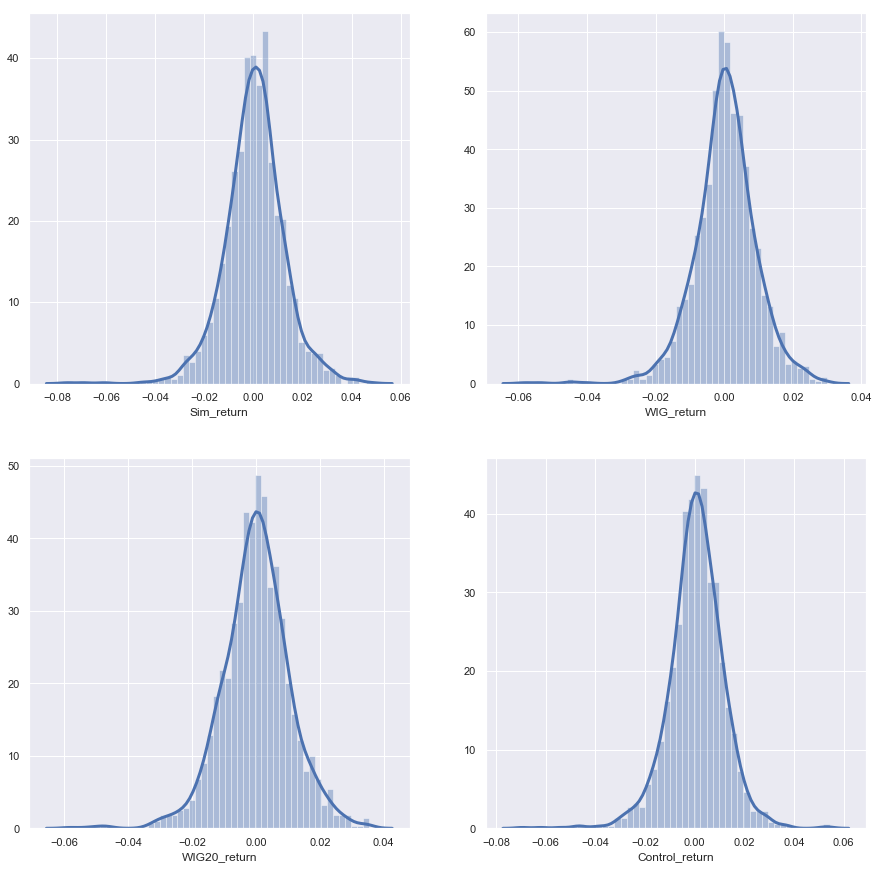

In [49]:
# Returns histogram - split 
f, axes = plt.subplots(2, 2, figsize=(15,15))

sns.distplot(df.Sim_return.dropna(), label="Symulacja", kde=True, ax=axes[0,0], bins=50, kde_kws = {'linewidth': 3})
sns.distplot(df.WIG_return.dropna(), label="WIG", kde=True, ax=axes[0,1], bins=50, kde_kws = {'linewidth': 3})
sns.distplot(df.WIG20_return.dropna(), label="WIG", kde=True, ax=axes[1,0], bins=50, kde_kws = {'linewidth': 3})
sns.distplot(df.Control_return.dropna(), label="Portfolio kontrolne", kde=True, ax=axes[1,1], bins=50, kde_kws = {'linewidth': 3})

[Text(0.5,0,'Return')]

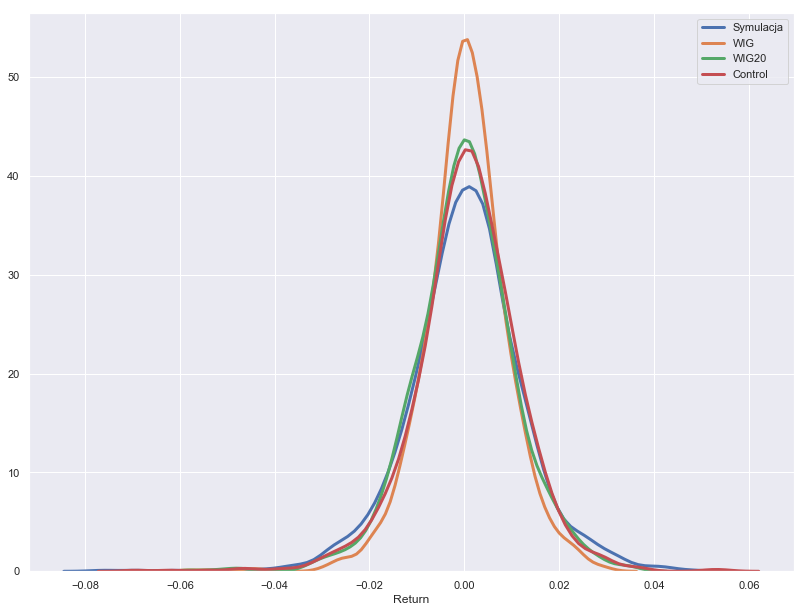

In [158]:
# Returns histogram - split 
 
ax = sns.distplot(df.Sim_return.dropna(), bins=50, hist=False, label="Symulacja", kde=True, kde_kws = {'linewidth': 3})
ax = sns.distplot(df.WIG_return.dropna(), bins=50,  hist=False, label="WIG", kde=True, kde_kws = {'linewidth': 3})
ax = sns.distplot(df.WIG20_return.dropna(),  bins=50, hist=False, label="WIG20", kde=True, kde_kws = {'linewidth': 3})
ax = sns.distplot(df.Control_return.dropna(), bins=50,  hist=False, label="Control", kde=True, kde_kws = {'linewidth': 3})
ax.set(xlabel='Return')

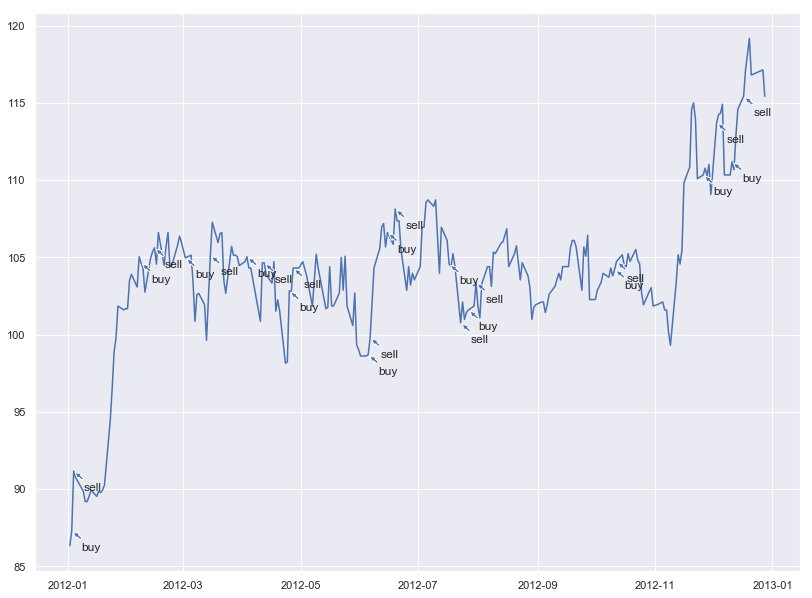

In [141]:
# Actions analysis
db = lite.connect("data/stocks_wig.db")
sim_action_log = pd.read_csv('runs/sim_run/action_log.csv', parse_dates=['Date'])
sim_action_log.drop(['Unnamed: 0'], axis=1, inplace=True)
sns.set(rc={'figure.figsize':(13.7,10.27)})

style = dict(size=10, color='black')

lwb_price = pd.read_sql("select Date, Close from data where Ticker = 'LWB' and Date like '%2012%'",db, parse_dates=['Date'], index_col='Date')
lwb_actions = sim_action_log[sim_action_log.Ticker == "LWB"]
lwb_actions = lwb_actions[lwb_actions.Date.dt.year == 2012]

fig, ax = plt.subplots() 
ax.plot(lwb_price)

for index, row in lwb_actions.iterrows():
    close = lwb_price[lwb_price.index == row.Date].Close
    close = float(close)
    ax.annotate(row.Action, xy=(row.Date, close), xytext=(10,-20), textcoords='offset points', arrowprops=dict(arrowstyle='simple'))



In [59]:
np.round(df.Control_return.skew(),4)

-0.4564

In [27]:
db = lite.connect('data/stocks_wig.db')
years = [(2011, 2012), (2012, 2013), (2013, 2014), (2014, 2015), (2015, 2016), (2016, 2017)]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=25)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=15)
    plt.yticks(tick_marks, classes, size=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", size=25)

    plt.tight_layout()
    plt.ylabel('Klasa rzeczywista', size=25)
    plt.xlabel('Klasa predykowana', size=25)

learning_set = pd.read_sql(f'select * from data where Date like "%{2011}%"; ', db)
learning_set.drop(['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return', 'Class'], axis=1, inplace=True)

df = pd.DataFrame(columns=learning_set.columns)
import os
print(os.getcwd())
def class_stat(years, cnf, df):        
    prev_year = years[0]
    c_year = years[1]
    learning_set = pd.read_sql(f'select * from data where Date like "%{prev_year}%"; ', db)
    class_set = learning_set['Class']
    learning_set.drop(['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return', 'Class'], axis=1, inplace=True)
    clf = tree.DecisionTreeClassifier(max_depth=5)
    clf.fit(learning_set, class_set)

    test_data =  pd.read_sql(f'select * from data where Date like "%{c_year}%"; ', db)
    test_class = test_data['Class']
    test_data.drop(['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return', 'Class'], axis=1,
                          inplace=True)
    df.loc[len(df)] = clf.feature_importances_
#     print(f"Year {c_year}")
#     for feat, importance in zip(learning_set.columns, clf.feature_importances_):
#         print(f"{feat} : {np.round(importance, 2)}")
#     print("-" * 20)
    pred = clf.predict(test_data)
    cnf += confusion_matrix(test_class, pred)
    return (pred, test_class)


cnf = np.zeros((2,2), dtype=int)

pred = []
classes = []
for y in years:
    data = class_stat(y, cnf, df)
    pred = [*pred, *data[0]]
    classes = [*classes, *data[1]]

df.to_csv('data\\b.csv', encoding='UTF8')
#accuracy_score(classes, pred)
    
# plot_confusion_matrix(cnf, classes=['Nierentowne', 'Rentowne'],
#                       title='Tablica pomyłek')

# print(cnf.sum())
# print(classification_report(test_class, pred))
# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# from sklearn.tree import export_graphviz
# import pydotplus
# import os     

# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

# dot_data = StringIO()
# export_graphviz(clf, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True, feature_names=learning_set.columns)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())



C:\dev\licencjat
